### Import Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('fivethirtyeight')

In [2]:
trips_by_day = pd.read_csv('data/trips_by_day.csv', parse_dates = [0])
dates = trips_by_day.date

trips_by_day.head()

,date,count
0,2010-09-20,212
1,2010-09-21,324
2,2010-09-22,377
3,2010-09-23,373
4,2010-09-24,362


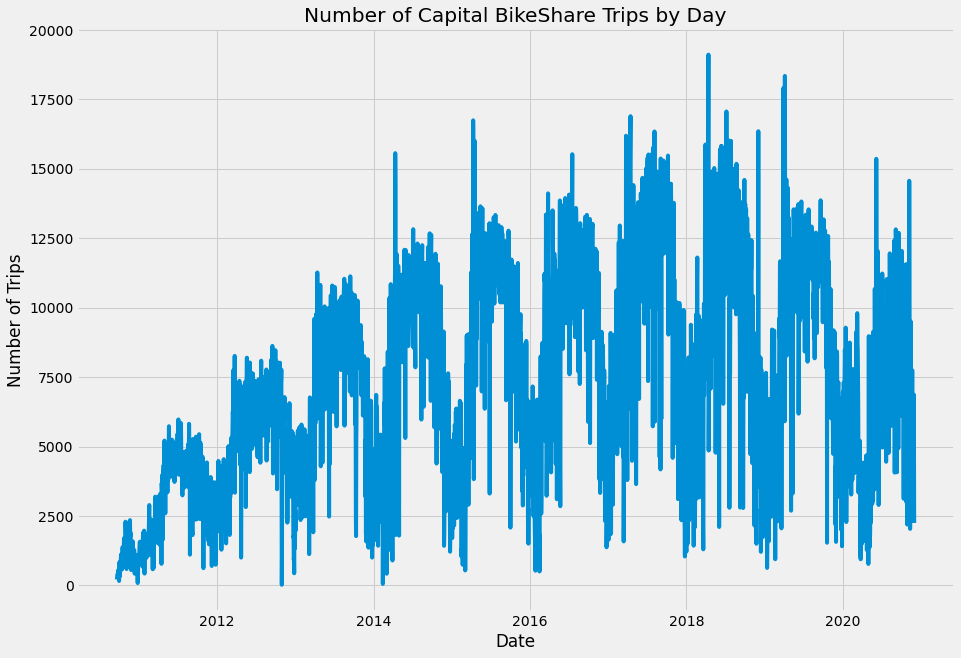

In [3]:
plt.figure(figsize = (14,10))
plt.plot(dates, trips_by_day['count'])
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.title('Number of Capital BikeShare Trips by Day')
plt.show()

With daily data, seasonality and trend are still visible but the data is too noisy to be used for forecasting.

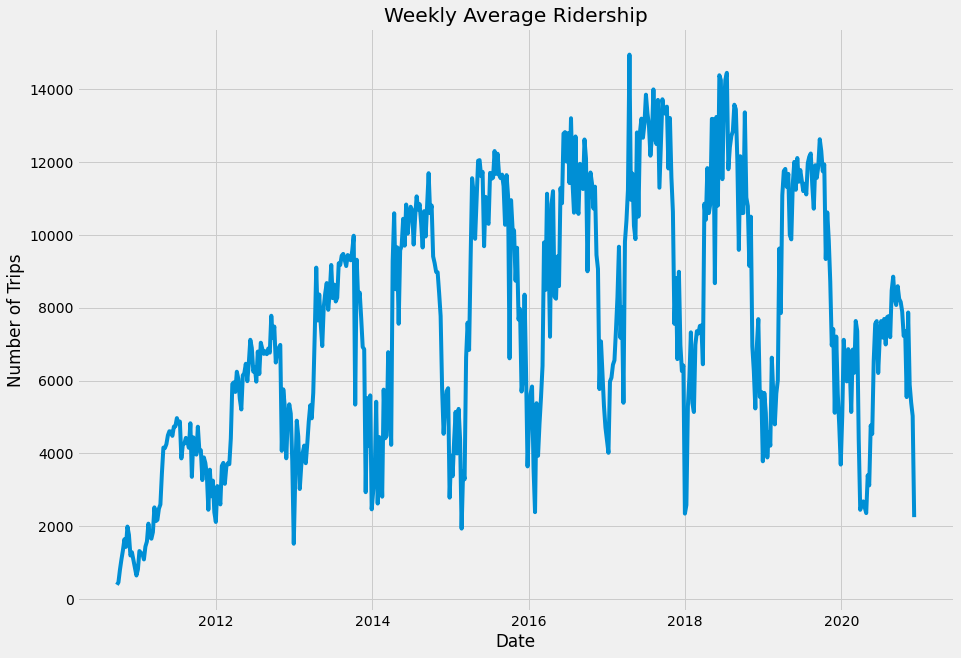

In [4]:
weekly_avg = trips_by_day.resample('W', on = 'date').mean()

plt.figure(figsize = (14,10))
plt.plot(weekly_avg)
plt.title('Weekly Average Ridership')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()

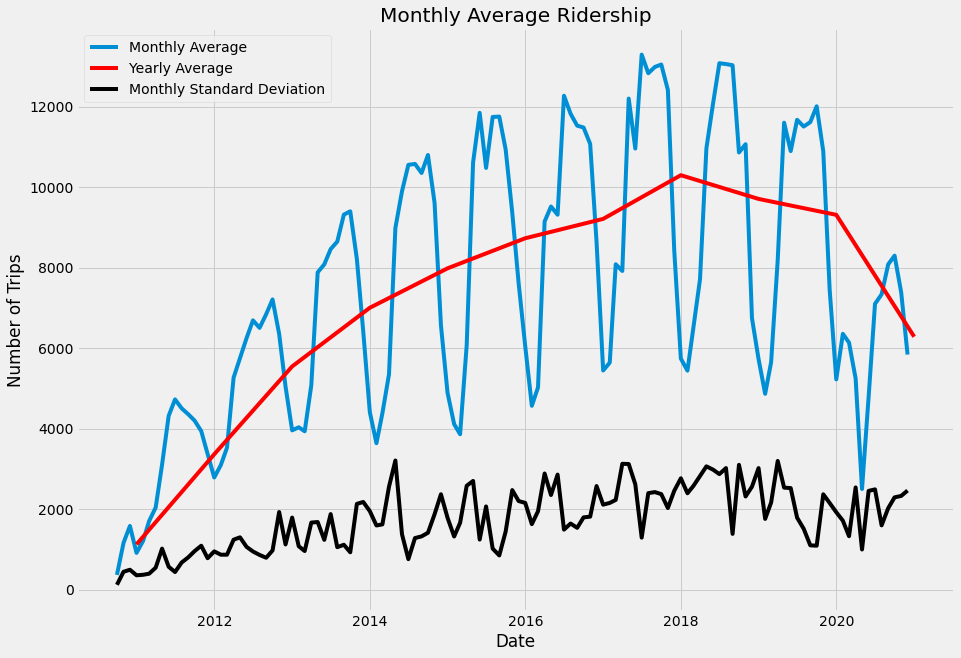

In [5]:
monthly_avg = trips_by_day.resample('M', on = 'date').mean()
yearly_avg = trips_by_day.resample('Y', on = 'date').mean()
monthly_std = trips_by_day.resample('M', on = 'date').std()

plt.figure(figsize = (14,10))
plt.plot(monthly_avg)
plt.plot(yearly_avg, color = 'red')
plt.plot(monthly_std, color = 'black')
plt.title('Monthly Average Ridership')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend(['Monthly Average', 'Yearly Average', 'Monthly Standard Deviation'])
plt.show()

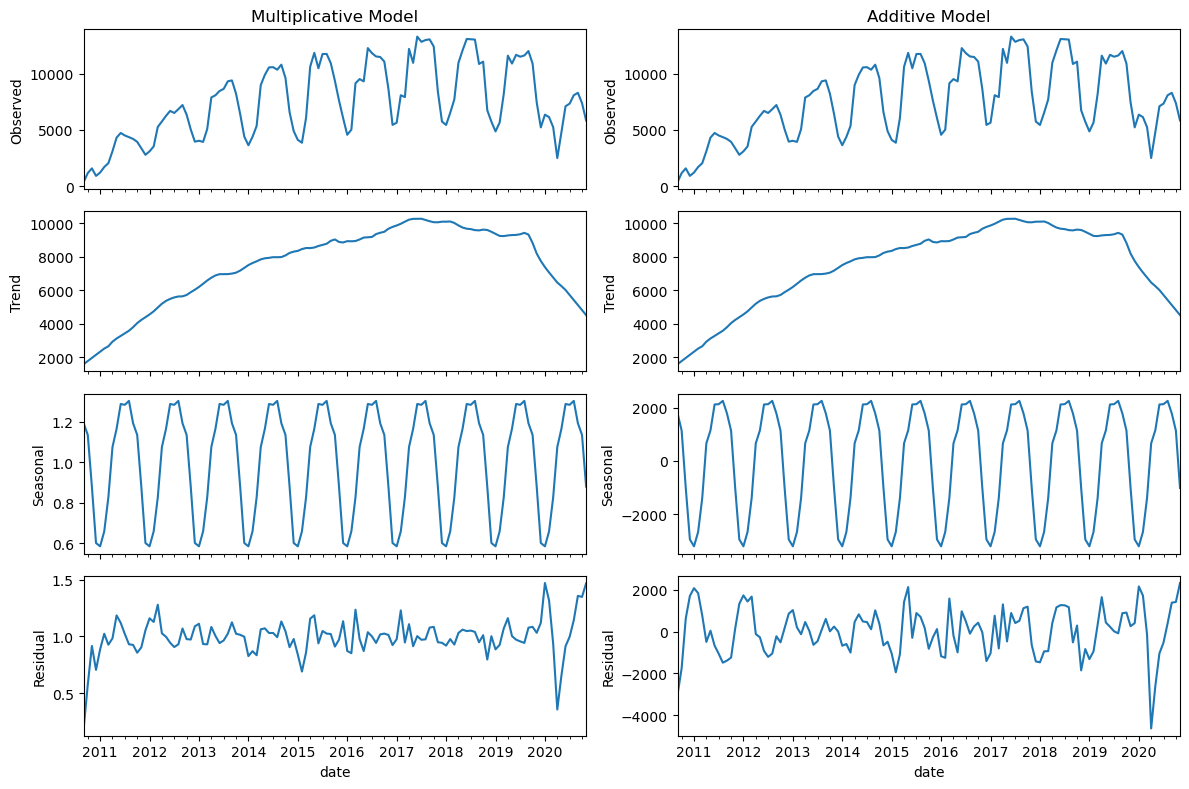

In [6]:
### Decompose time series using Multiplicative/Additive Model ###
plt.style.use('default')
decomposition_mult = seasonal_decompose(monthly_avg, 
                                   model = 'multi', 
                                   period = 12, 
                                   extrapolate_trend = 'freq')

decomposition_add = seasonal_decompose(monthly_avg, 
                                   model = 'add', 
                                   period = 12, 
                                   extrapolate_trend = 'freq')

### Plot decomposed time series ###
def plot_decomposition(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(4,2, sharex = True, figsize = (12,8))

plot_decomposition(decomposition_mult, axes[:,0])
axes[0][0].set_title('Multiplicative Model')

plot_decomposition(decomposition_add, axes[:,1])
axes[0][1].set_title('Additive Model')

plt.tight_layout()
plt.show()

### Stationarize Time Series

In [7]:
monthly_avg['trend'] = decomposition_mult.trend

In [8]:
monthly_avg['first_diff'] = monthly_avg['count'] - monthly_avg['count'].shift(1)

In [9]:
monthly_avg['detrend'] = monthly_avg['count'] - monthly_avg['trend']

In [10]:
def test_stationarity(series):
    
    test_dates = series.index
    
    # Rolling statistics
    rol_avg = series.rolling(window = 365).mean()
    rol_std = series.rolling(window = 365).std()
    
    # Plotting Statistics
    plt.figure(figsize = (8,5))
    plt.plot(series)
    plt.plot(test_dates, rol_avg, color = 'r')
    plt.plot(test_dates, rol_std, color = 'k')
    plt.xlabel('Date')
    plt.legend(['Series', 'Yearly Rolling Mean', 'Yearly Rolling St. Dev.'])
    plt.show()
    
    # Dickey-Fuller Test:
    test = adfuller(series, autolag = 'AIC')
    result = pd.Series(test[0:4], index = ['Test Statistic', 'P-value', '# of Lags Used', '# of Observations used'])
    for key, value in test[4].items():
        result[f'Critical Value ({key})'] = value
    
    print('Dickey-Fuller Test Results:')
    print(result)

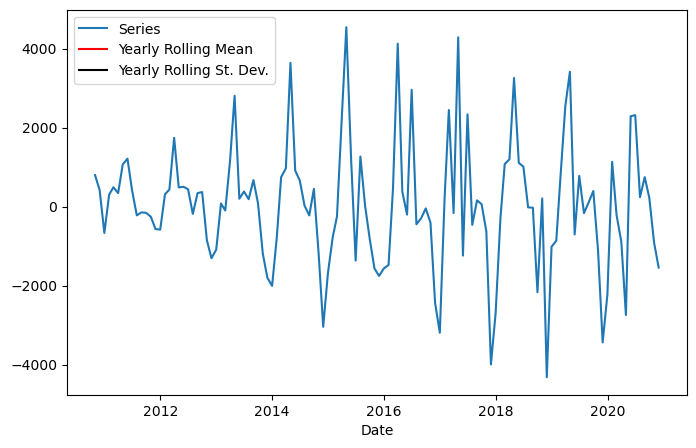

Dickey-Fuller Test Results:
Test Statistic             -3.950177
P-value                     0.001695
# of Lags Used             11.000000
# of Observations used    110.000000
Critical Value (1%)        -3.491245
Critical Value (5%)        -2.888195
Critical Value (10%)       -2.580988
dtype: float64


In [11]:
test_stationarity(monthly_avg['first_diff'].dropna())

Taking the first difference of the data resulted in a pretty stationary time series as can be seen from the extremely low P-value. Let's see how removing the trend performs.

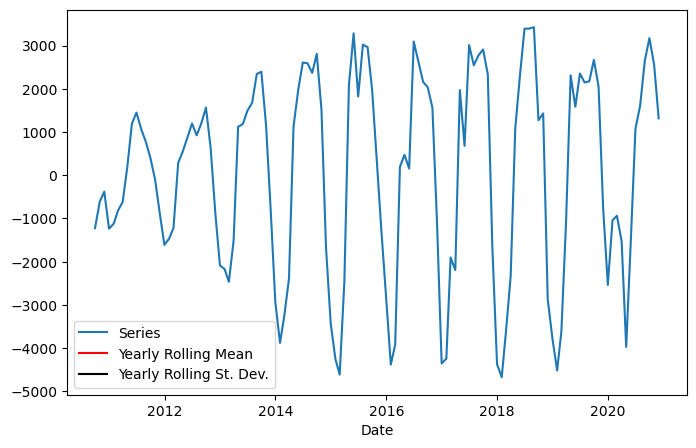

Dickey-Fuller Test Results:
Test Statistic           -6.189524e+00
P-value                   6.171267e-08
# of Lags Used            1.300000e+01
# of Observations used    1.090000e+02
Critical Value (1%)      -3.491818e+00
Critical Value (5%)      -2.888444e+00
Critical Value (10%)     -2.581120e+00
dtype: float64


In [12]:
test_stationarity(monthly_avg['detrend'])

By subtracting the overall trend from the data, the time series becomes significantly more stationarized than using the first difference method. This will be used to model and forecast the data using ARIMA/SARIMA models.

### Plotting ACF and PACF

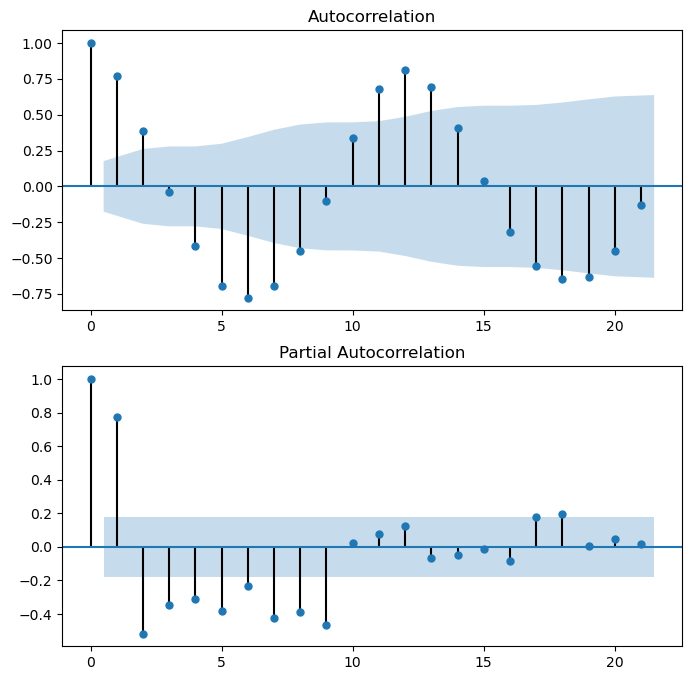

In [13]:
fig = plt.figure(figsize = (8,8))

ax1 = fig.add_subplot(211)
acf = plot_acf(monthly_avg['detrend'].dropna(), ax = ax1)

ax2 = fig.add_subplot(212)
pacf = plot_pacf(monthly_avg['detrend'].dropna(), ax = ax2)

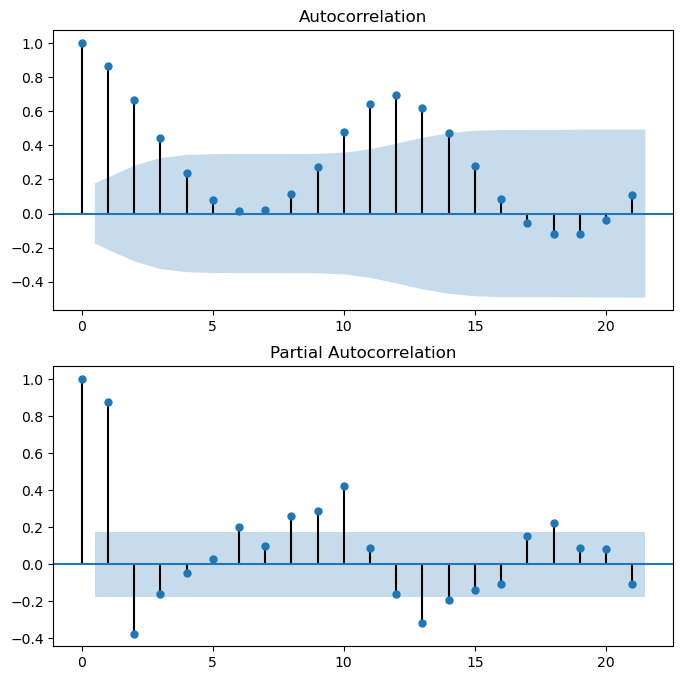

In [14]:
fig = plt.figure(figsize = (8,8))

ax1 = fig.add_subplot(211)
acf = plot_acf(monthly_avg['count'].dropna(), ax = ax1)

ax2 = fig.add_subplot(212)
pacf = plot_pacf(monthly_avg['count'].dropna(), ax = ax2)

### Modeling with ARIMA and SARIMAX

In [15]:
import pmdarima as pm

model = pm.auto_arima(monthly_avg['detrend'], start_p = 0, max_p = 2,
                     start_q = 0, max_q = 2, d = 1, seasonal = True,
                     m = 12, start_P = 0, max_P = 2, start_Q = 0, max_Q = 2,
                     error_action = 'ignore',
                     suppress_warnings = True)

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  123
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1042.987
Date:                              Wed, 27 Jan 2021   AIC                           2091.975
Time:                                      22:07:11   BIC                           2100.387
Sample:                                           0   HQIC                          2095.391
                                              - 123                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8929      0.073     12.253      0.000       0.750       1.036
ma.S.L12      -0.5745      0.151     -3.796      0.000      -0.871      -0.278
sigma2       1.48e+06   1.43e+05     10.370      0.000     1.2e+06    1.76e+06
===================================================================================
Ljung-Box (Q):                       66.36   Jarque-Bera (JB):                16.37
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               3.42   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model = pm.auto_arima(monthly_avg['count'], start_p = 0, max_p = 2,
                     start_q = 0, max_q = 2, d = 1, seasonal = True,
                     m = 12, start_P = 0, max_P = 2, start_Q = 0, max_Q = 2,
                     error_action = 'ignore',
                     suppress_warnings = True)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  123
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1038.172
Date:                            Wed, 27 Jan 2021   AIC                           2086.343
Time:                                    22:07:33   BIC                           2100.363
Sample:                                         0   HQIC                          2092.038
                                            - 123                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6921      0.161      4.292      0.000       0.376       1.008
ma.L1         -0.9038      0.110     -8.228      0.000      -1.119      -0.689
ar.S.L12       0.8699      0.079     10.966      0.000       0.714       1.025
ma.S.L12      -0.4584      0.169     -2.709      0.007      -0.790      -0.127
sigma2      1.358e+06   1.21e+05     11.248      0.000    1.12e+06    1.59e+06
===================================================================================
Ljung-Box (Q):                       57.54   Jarque-Bera (JB):               114.31
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

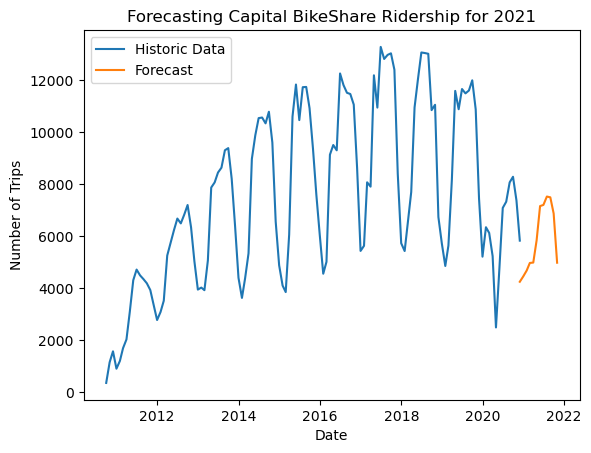

In [17]:
forecast_result = model.predict(n_periods = 12)
forecast_dates = pd.date_range(start = monthly_avg['count'].index[-1], periods = len(forecast_result), freq = 'M')

plt.plot(monthly_avg['count'])
plt.plot(forecast_dates, forecast_result)
plt.title('Forecasting Capital BikeShare Ridership for 2021')
plt.legend(['Historic Data', 'Forecast'])
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()


Although the forecast, follows the trend, this may not paint an accurate picture of what is to be expected for 2021. With the COVID-19 vaccine being administered across the nation, we can expect the country to return to some level of normalcy.

In [18]:
train_2019 = monthly_avg[monthly_avg.index < '2020-01-01']

model_2019 = pm.auto_arima(train_2019['count'], start_p = 0, max_p = 2,
                     start_q = 0, max_q = 2, d = 1, seasonal = True,
                     m = 12, start_P = 0, max_P = 2, start_Q = 0, max_Q = 2,
                     error_action = 'ignore',
                     suppress_warnings = True)

model_2019.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  112
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -825.032
Date:                            Wed, 27 Jan 2021   AIC                           1658.063
Time:                                    22:07:44   BIC                           1668.444
Sample:                                         0   HQIC                          1662.263
                                            - 112                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3787      0.138      2.747      0.006       0.109       0.649
ma.L1         -0.8509      0.087     -9.769      0.000      -1.022      -0.680
ma.S.L12      -0.4278      0.101     -4.242      0.000      -0.625      -0.230
sigma2      9.926e+05   1.65e+05      6.007      0.000    6.69e+05    1.32e+06
===================================================================================
Ljung-Box (Q):                       74.09   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.00   Prob(JB):                         0.62
Heteroskedasticity (H):               1.01   Skew:                             0.24
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

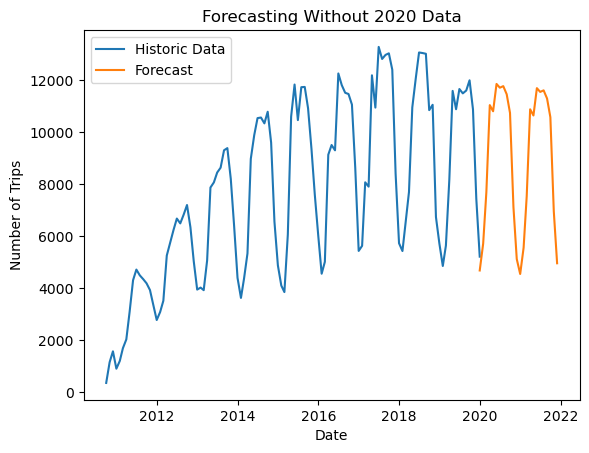

In [19]:
forecast_2019 = model_2019.predict(n_periods = 24)
forecast_2019_dates = pd.date_range(start = train_2019.index[-1], periods = len(forecast_2019), freq = 'M')

plt.plot(train_2019['count'])
plt.plot(forecast_2019_dates, forecast_2019)
plt.title('Forecasting Without 2020 Data')
plt.legend(['Historic Data', 'Forecast'])
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()


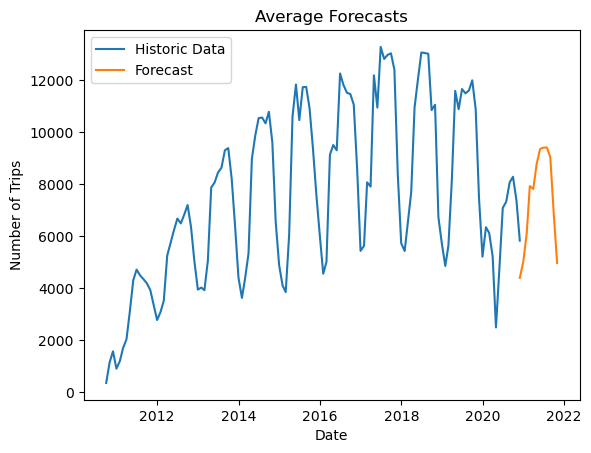

In [20]:
forecast_avg = np.average((forecast_2019[-12:], forecast_result) ,axis = 0)

plt.plot(monthly_avg['count'])
plt.plot(forecast_dates, forecast_avg)
plt.title('Average Forecasts')
plt.legend(['Historic Data', 'Forecast'])
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()

When taking the average of the two forecasts generated (one using 2020 data and the other excluding 2020 data), we obtain a more reasonable forecast of the bike usage in 2021. Usage will start off low during the early parts of the year as it will still be cold in Washington DC, but will continue to increase and see peak usage during the spring/summer times. However, it would be naive to expect the usage to increase to regular levels in all areas of Washington DC. Until companies are reopening their offices for employees to come work, the demand for bikes will not return to normal, specifically in the central areas of the city. Because of this, I want to analyze how the usage trends differ between the center and outskirts of Washington D.C.

### Analyze by Central and Outskirt Areas

To analyze the different usage trends in both the central and outer areas of Washington D.C., I defined an arbitrary zone bounded by (38.88, 38.92) in latitude and (-77.05, 76.97) in longitude as the central area of Washington DC. What I'm classifying as the central area of DC is the area within the red rectangle in the image below, all areas outside the rectangle are considered the outskirts of DC. <img src="DC_satellite_image_square.jpg" width = 400>

In [21]:
central = pd.read_csv('data/central_trips.csv', parse_dates = [0], index_col = 0)
outskirts = pd.read_csv('data/outskirts_trips.csv', parse_dates = [0], index_col = 0)

display(central.head(), outskirts.head())

,count
date,
2010-09-20,131
2010-09-21,201
2010-09-22,223
2010-09-23,234
2010-09-24,221


,count
date,
2010-09-20,81
2010-09-21,123
2010-09-22,154
2010-09-23,139
2010-09-24,141


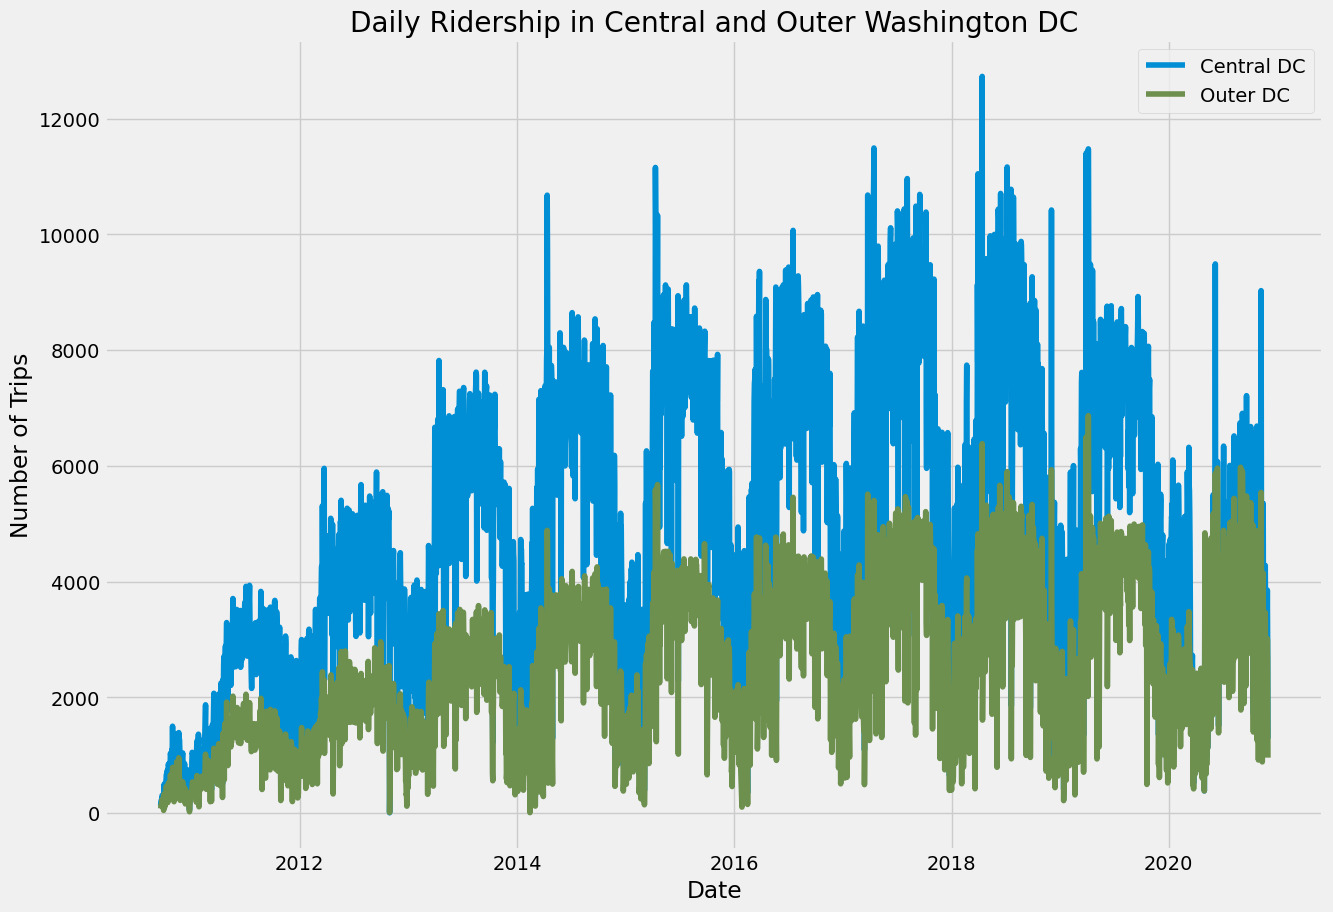

In [22]:
plt.style.use('fivethirtyeight')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']   

plt.figure(figsize = (14,10))
plt.plot(central, label = 'Central DC')
plt.plot(outskirts, label = 'Outer DC', color = colors[-3])
plt.title('Daily Ridership in Central and Outer Washington DC')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.show()

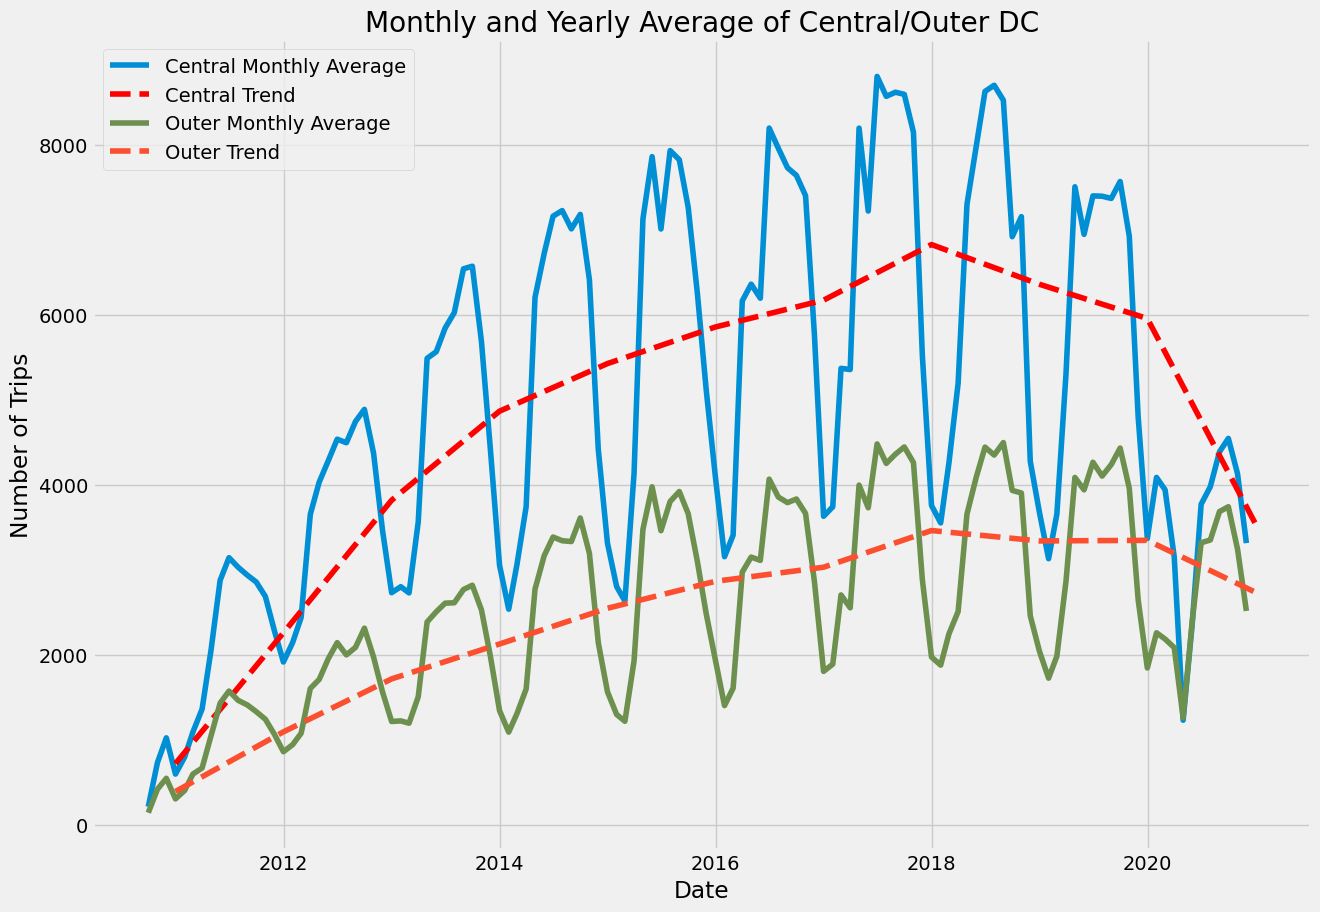

In [23]:
central_monthly = central.resample('M').mean()
central_yearly = central.resample('Y').mean()

outskirts_monthly = outskirts.resample('M').mean()
outskirts_yearly = outskirts.resample('Y').mean()

plt.figure(figsize = (14,10))
plt.plot(central_monthly, label = 'Central Monthly Average')
plt.plot(central_yearly, color = 'red', linestyle = '--', label = 'Central Trend')
plt.plot(outskirts_monthly, color = colors[-3], label = 'Outer Monthly Average')
plt.plot(outskirts_yearly, linestyle = '--', label = 'Outer Trend')
plt.title('Monthly and Yearly Average of Central/Outer DC')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.show()

Up until 2018, there was almost a linear increase in the number of trips taken outside of central DC and almost a plateau in 2018-2019. This can be attributed to the gradual increase of the new stations available in the outskirts of the city. We can also see that the outskirts of DC did not see as much of a drastic impact on ridership than in the central areas of Washington DC. There was a dip in usage in March, just not as significant as the decrease seen in the center of DC. 

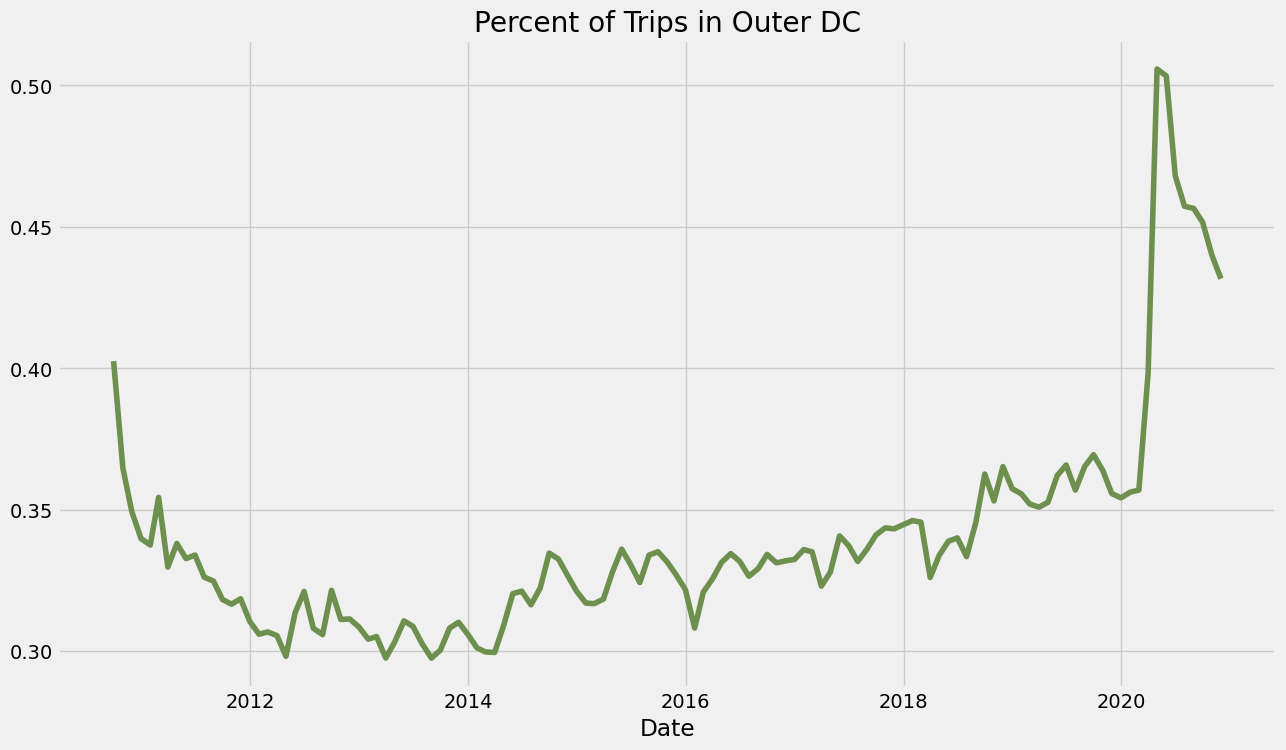

In [24]:
percent_ridership = pd.DataFrame(columns = ['Central', 'Outskirts'])
percent_ridership['Central'] = central_monthly['count']/monthly_avg['count']
percent_ridership['Outskirts'] = outskirts_monthly['count']/monthly_avg['count']


plt.figure(figsize = (14,8))
plt.plot(percent_ridership['Outskirts'], color = colors[-3])
plt.title('Percent of Trips in Outer DC')
plt.xlabel('Date')
plt.show()


When looking at the percent of ridership in the outskirts of the city, we see an immense spike in the early portion of 2020. With COVID-19 forcing many people into lockdowns and work-from-home situations, there was a significant decrease in the demand of bikes in central DC with an increase in demand of bikes in the outskirts. This decrease in demand of bikes in central DC may [continue until the end of the summer in 2021](https://www.npr.org/sections/coronavirus-live-updates/2020/09/15/913154140/workers-in-washington-d-c-region-likely-to-work-from-home-until-next-summer), with some companies, like Twitter, permanently working from home. Because of this, we can expect to see the percent of ridership in the outskirts of DC to stay in its elevated range as more and more people will continue to utilize the bikes station in the numerous parks across the city.

In [25]:
outskirts_model = pm.auto_arima(outskirts_monthly, start_p = 0, max_p = 2,
                     start_q = 0, max_q = 2, d = 1, seasonal = True,
                     m = 12, start_P = 0, max_P = 2, start_Q = 0, max_Q = 2,
                     error_action = 'ignore',
                     suppress_warnings = True)

outskirts_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  123
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -903.969
Date:                            Wed, 27 Jan 2021   AIC                           1817.938
Time:                                    22:08:14   BIC                           1831.958
Sample:                                         0   HQIC                          1823.632
                                            - 123                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6209      0.138      4.515      0.000       0.351       0.890
ma.L1         -0.9126      0.082    -11.190      0.000      -1.072      -0.753
ar.S.L12       0.8961      0.074     12.181      0.000       0.752       1.040
ma.S.L12      -0.4658      0.173     -2.693      0.007      -0.805      -0.127
sigma2      1.477e+05    1.3e+04     11.355      0.000    1.22e+05    1.73e+05
===================================================================================
Ljung-Box (Q):                       62.76   Jarque-Bera (JB):               145.50
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               3.17   Skew:                            -1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

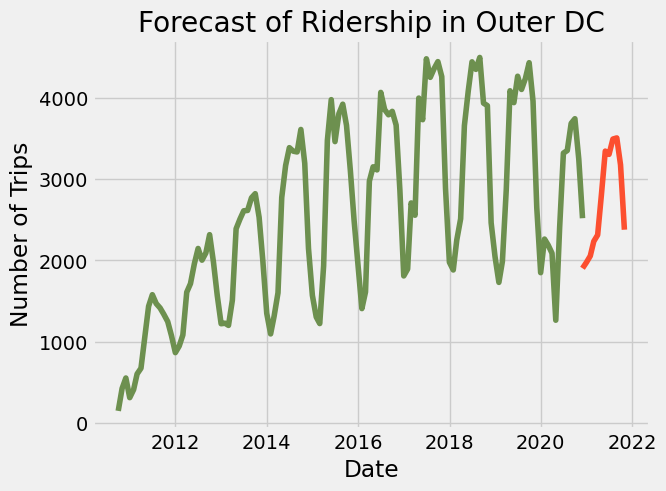

In [26]:
outskirts_forecast = outskirts_model.predict(n_periods = 12)

plt.plot(outskirts_monthly, color = colors[-3])
plt.plot(forecast_dates, outskirts_forecast, color = colors[1])
plt.title('Forecast of Ridership in Outer DC')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()

In [27]:
central_model = pm.auto_arima(central_monthly, start_p = 0, max_p = 2,
                     start_q = 0, max_q = 2, d = 1, seasonal = True,
                     m = 12, start_P = 0, max_P = 2, start_Q = 0, max_Q = 2,
                     error_action = 'ignore',
                     suppress_warnings = True)

central_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  123
Model:             SARIMAX(2, 1, 2)x(2, 0, [], 12)   Log Likelihood                -988.140
Date:                             Wed, 27 Jan 2021   AIC                           1990.281
Time:                                     22:08:42   BIC                           2009.909
Sample:                                          0   HQIC                          1998.253
                                             - 123                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7031      0.068     24.884      0.000       1.569       1.837
ar.L2         -0.9198      0.070    -13.123      0.000      -1.057      -0.782
ma.L1         -1.8410      0.146    -12.629      0.000      -2.127      -1.555
ma.L2          0.9615      0.147      6.525      0.000       0.673       1.250
ar.S.L12       0.1627      0.148      1.095      0.273      -0.128       0.454
ar.S.L24       0.1897      0.155      1.223      0.221      -0.114       0.494
sigma2      8.928e+05   1.52e+05      5.868      0.000    5.95e+05    1.19e+06
===================================================================================
Ljung-Box (Q):                       41.41   Jarque-Bera (JB):                33.43
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               3.51   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

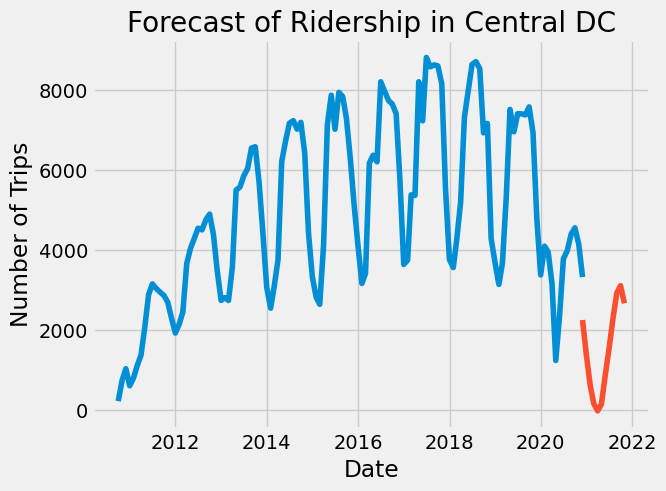

In [28]:
central_forecast = central_model.predict(n_periods = 12)

plt.plot(central_monthly)
plt.plot(forecast_dates, central_forecast, color = colors[1])
plt.title('Forecast of Ridership in Central DC')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()

The data from 2020 significantly impacted the forecast for 2021 as the model is forecasting that there will once again be another dip in the bike usage around March, which obviously will not be the case (knock on wood).

With the forecast and analysis of bike usage trends, it would be wise for Capital BikeShare to not expect bike demands to return to normal, especially for central DC. However, be prepared to accommodate for the increase in demand, compared to normal levels, for bikes in the outer areas of DC, specifically park areas where people may be able to utilize the bikes more for enjoyment and exercise rather than a means of transportation. 